<a href="https://colab.research.google.com/github/shravanineeli/ML_Projects/blob/main/Titanic_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starter Code


Variable	Definition	Key
- Survived	Survival	0 = No, 1 = Yes
- Pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- Sex	Sex
- Age	Age in years
- Sibsp	# of siblings / spouses aboard the Titanic
- Parch	# of parents / children aboard the Titanic
- Ticket	Ticket number
- Fare	Passenger fare
- Cabin	Cabin number
- Embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load the Titanic dataset
titanic = sns.load_dataset('titanic')

# Print the first few rows of the dataset
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


# Data Exploration

## Shape

In [ ]:
titanic.shape

(891, 15)

The dataset has 15 columns and 891 rows of data.

## Types

In [ ]:
titanic.dtypes

,0
survived,int64
pclass,int64
sex,object
age,float64
sibsp,int64
parch,int64
fare,float64
embarked,object
class,category
who,object


The columns 'survived', 'pclass', 'sex', 'embarked', 'who', 'embark_town', and 'alive' need to be changed from object to categorical columns.

In [ ]:
titanic['survived'] = titanic['survived'].astype('category')
titanic['pclass'] = titanic['pclass'].astype('category')
titanic['sex'] = titanic['sex'].astype('category')
titanic['embarked'] = titanic['embarked'].astype('category')
titanic['who'] = titanic['who'].astype('category')
titanic['embark_town'] = titanic['embark_town'].astype('category')
titanic['alive'] = titanic['alive'].astype('category')

In [ ]:
titanic.dtypes

,0
survived,category
pclass,category
sex,category
age,float64
sibsp,int64
parch,int64
fare,float64
embarked,category
class,category
who,category


The column 'alive' and 'survived', 'pclass' and 'class', and 'embarked' and 'embark_town' all seems to be repeating the same information as each other.

I will check the unique values of each column, and if there are the same, then, one of the columns will be delete to avoid multicollinearity.

In [ ]:
titanic['alive'].value_counts()

,count
alive,
no,549
yes,342


In [ ]:
titanic['survived'].value_counts()

,count
survived,
0,549
1,342


In [ ]:
titanic['embarked'].value_counts()

,count
embarked,
S,644
C,168
Q,77


In [ ]:
titanic['embark_town'].value_counts()

,count
embark_town,
Southampton,644
Cherbourg,168
Queenstown,77


In [ ]:
titanic['pclass'].value_counts()

,count
pclass,
3,491
1,216
2,184


In [ ]:
titanic['class'].value_counts()

,count
class,
Third,491
First,216
Second,184


From the unique value counts, we can see that 'alive' and 'survived' are the same as they have the same number rows in yes or 1 and no or 0.

Similarly, the 'embarked' and 'embark_town' columns also have the same count of rows for each of the categories 'S', 'C', 'Q', 'Southhampton', 'Cherbourg', and 'Queenstown'.

We can also have either 'class' or 'pclass' as they have the same information.

So we will be dropping 'class', 'alive', and 'embarked'.

In [ ]:
titanic = titanic.drop(columns=['alive', 'embarked', 'class'], axis=1)

In [ ]:
titanic.shape

(891, 12)

## Missing Values

In [ ]:
titanic.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
who,0
adult_male,0
deck,688


I will be dropping the column deck as it more than 77% missing values.

However, I will impute the missing values in 'embark_town' and 'age'.

I will use the mode value of 'embark_town' to impute the missing values.

For 'age', I will look at the column 'who' and check whether the row has 'man' or 'woman', if it does I will impute 22; and if not, I will imput 13.

In [ ]:
# Fill missing values in 'embark_town' with the mode
titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace=True)

# Define a function to impute age based on the value of 'who'
def impute_age(row):
    if pd.isnull(row['age']):  # Check if age is missing
        if row['who'] == 'man' or row['who'] == 'woman':
            return titanic['age'].median()  # Impute median age for adults
        elif row['who'] == 'child':
            return 13  # Impute age as 13 for children
    return row['age']  # Return the original age if not missing

# Apply the function to the DataFrame
titanic['age'] = titanic.apply(impute_age, axis=1)

# Dropping Deck
titanic.drop('deck', axis=1, inplace=True)

<ipython-input-16-dbd6a793eec4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace=True)


In [ ]:
titanic.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
who,0
adult_male,0
embark_town,0


# EDA

## Histograms

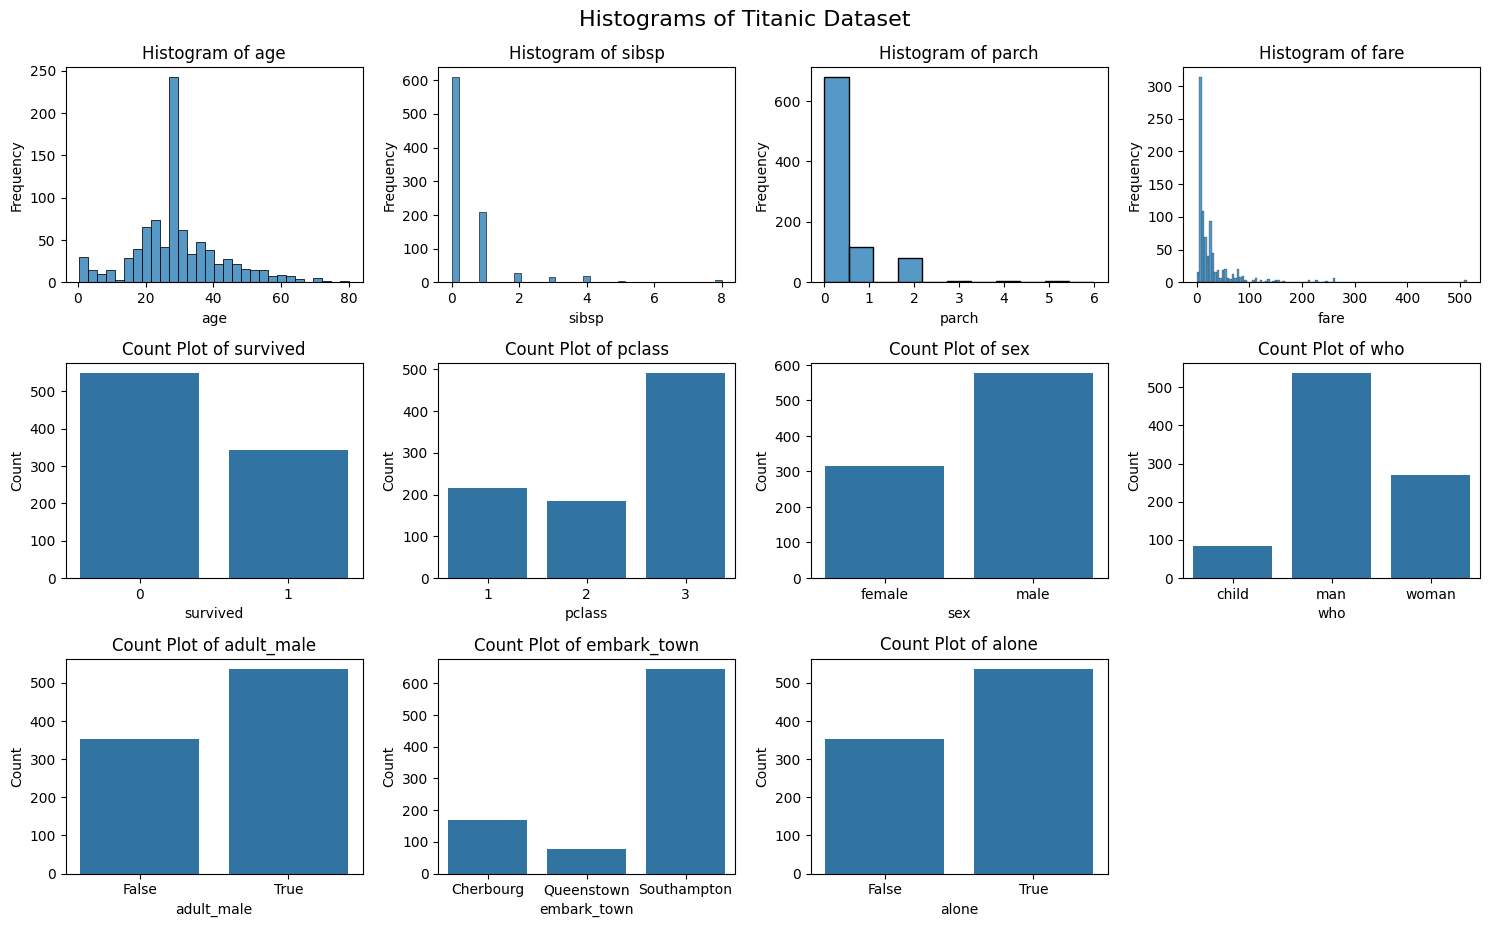

In [ ]:
# Set up the figure for multiple plots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
fig.suptitle('Histograms of Titanic Dataset', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Separate numerical and categorical columns
numeric_columns = titanic.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = titanic.select_dtypes(include=['bool', 'category']).columns

# Initialize a counter for the plots
plot_idx = 0

# Plot histograms for numerical columns
for col in numeric_columns:
    if titanic[col].nunique(dropna=True) > 1:
        sns.histplot(titanic[col], ax=axes[plot_idx], kde=False)
        axes[plot_idx].set_xlabel(col)
        axes[plot_idx].set_ylabel('Frequency')
        axes[plot_idx].set_title(f'Histogram of {col}')
        plot_idx += 1

# Plot bar plots for categorical columns
for col in categorical_columns:
    if titanic[col].nunique(dropna=True) > 1:
        sns.countplot(x=titanic[col], ax=axes[plot_idx])
        axes[plot_idx].set_xlabel(col)
        axes[plot_idx].set_ylabel('Count')
        axes[plot_idx].set_title(f'Count Plot of {col}')
        plot_idx += 1

# Remove any unused subplots
for ax in axes[plot_idx:]:
    fig.delaxes(ax)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

### Analysis of Histograms

The column 'age' has a normal distribution with an extremely populated median. This is as a result of imputing the missing values.

The columns 'sibsp', 'parch', and 'fare' have an exponential decay. This is is logical as 'sibsp' and 'parch' represent the number of people which tends to decrease as the count goes higher. The fare seems to be mostly within the range of 0-100.

## Boxplots

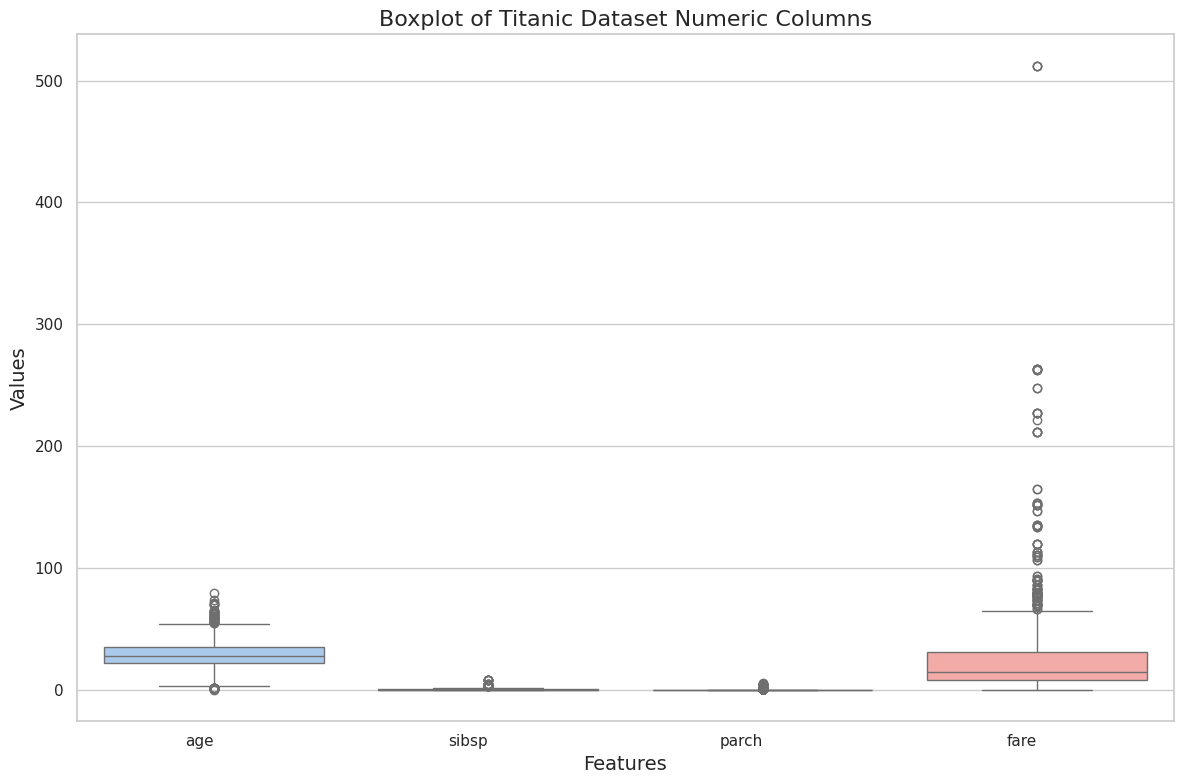

In [ ]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the style for the plot
sns.set(style="whitegrid")

# Set a color palette that matches the number of numeric columns (4 in this case)
palette = sns.color_palette("pastel", n_colors=4)

# Select only the numeric columns from the Titanic dataset
numeric_columns = titanic.select_dtypes(include=['float64', 'int64']).columns

# Create a figure for the boxplots
plt.figure(figsize=(12, 8))

# Create the boxplot for the numeric columns
sns.boxplot(data=titanic[numeric_columns], palette=palette)

# Add titles and labels
plt.title('Boxplot of Titanic Dataset Numeric Columns', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(ha='right')

# Show the plot
plt.tight_layout()
plt.show()

Through the boxplot, it is evident that the features need to be scaled.

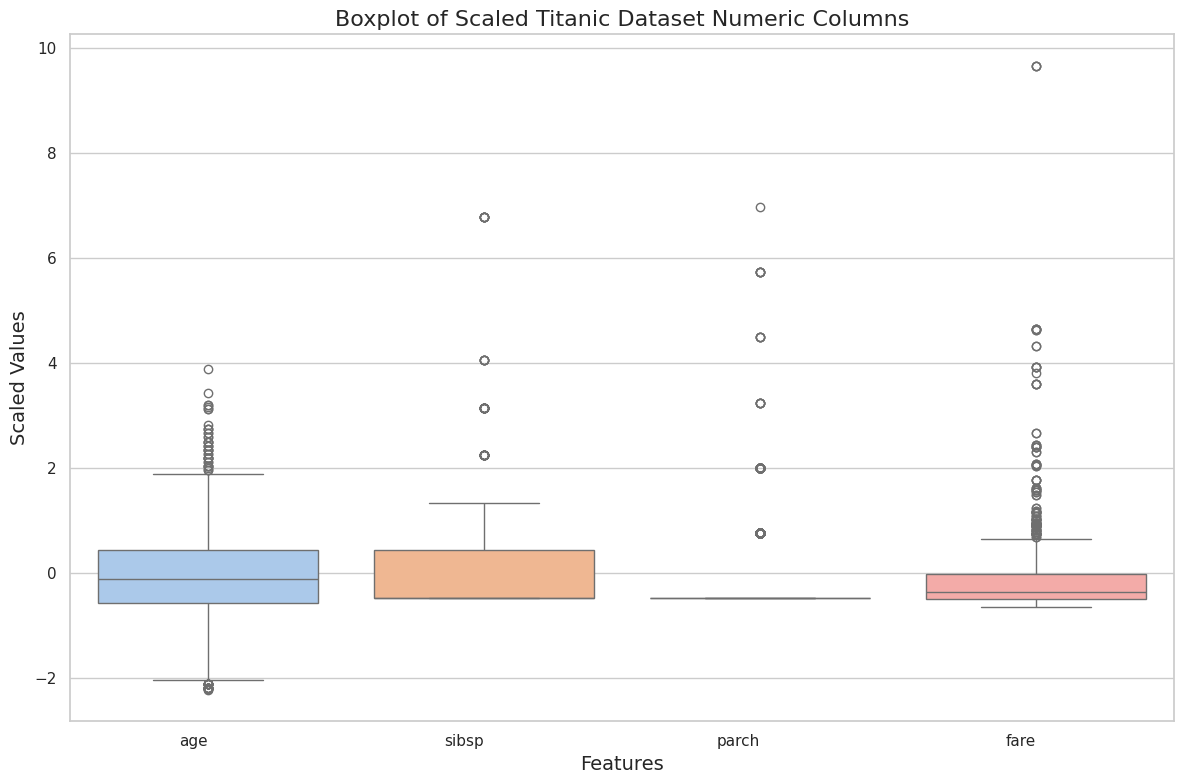

In [ ]:
# Select only the numeric columns from the Titanic dataset
numeric_columns = titanic.select_dtypes(include=['float64', 'int64']).columns

# Standardize the numeric columns using StandardScaler
scaler = StandardScaler()
titanic_scaled = titanic.copy()
titanic_scaled[numeric_columns] = scaler.fit_transform(titanic[numeric_columns])

# Set the style for the plot
sns.set(style="whitegrid")

# Set a color palette
palette = sns.color_palette("pastel", n_colors=len(numeric_columns))

# Create a figure for the boxplots
plt.figure(figsize=(12, 8))

# Create the boxplot for the scaled numeric columns
sns.boxplot(data=titanic_scaled[numeric_columns], palette=palette)

# Add titles and labels
plt.title('Boxplot of Scaled Titanic Dataset Numeric Columns', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Scaled Values', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(ha='right')

# Show the plot
plt.tight_layout()
plt.show()

### Analysis of Boxplots

After scaling the dataset, there are still many outliers present in all the features.

However, none of the outliers will be removed because for 'sibsp' and 'parch' since their unique values are very low, removing the outliers could be detrimental for the variance in feature.

No outliers will be removed for 'age' and 'fare' as well, since we would have to remove more than 5% of the dataset to get rid of all outliers.

## Correlation Matrix

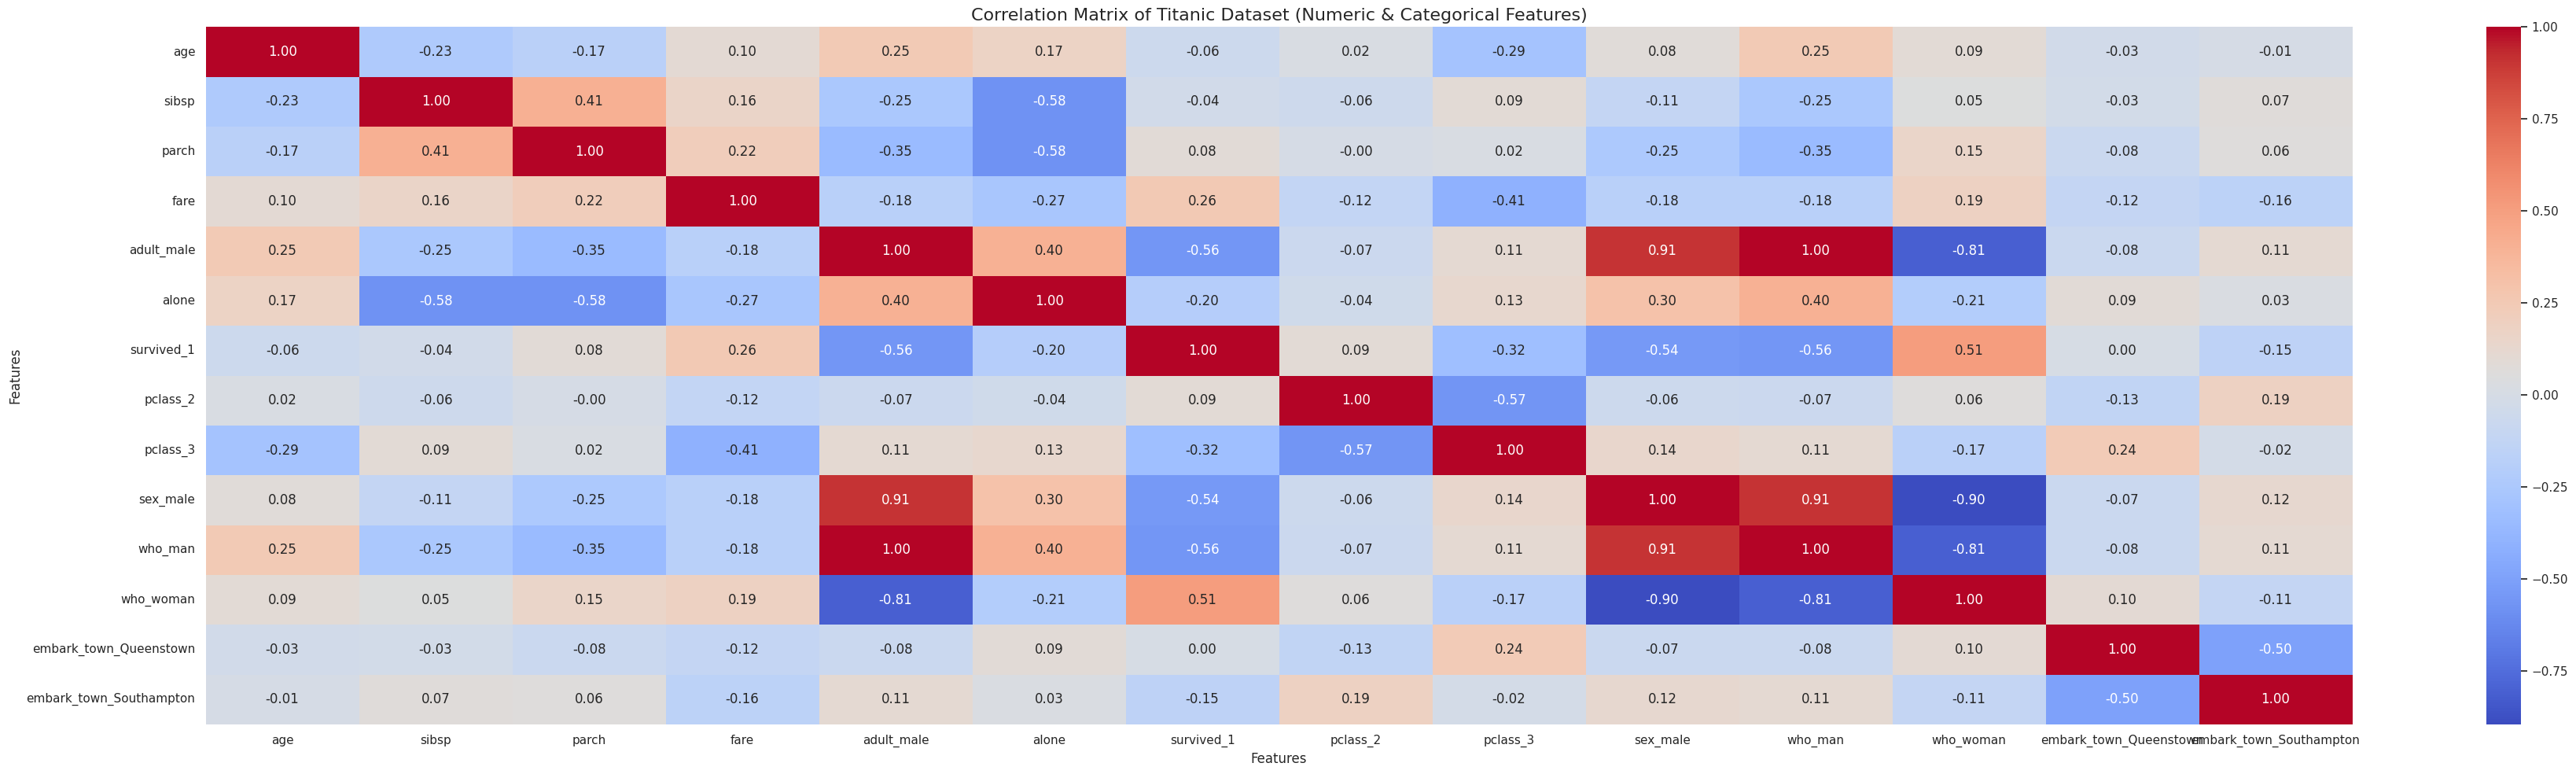

In [ ]:
# Select numeric and categorical columns
numeric_columns = titanic.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = titanic.select_dtypes(include=['object', 'category', 'bool']).columns

# One-hot encode the categorical columns
titanic_encoded = pd.get_dummies(titanic[categorical_columns], drop_first=True)

# Combine the numeric and encoded categorical columns
titanic_final = pd.concat([titanic[numeric_columns].reset_index(drop=True), titanic_encoded.reset_index(drop=True)], axis=1)

# Calculate the correlation matrix
correlation_matrix = titanic_final.corr()

# Set up the matplotlib figure
plt.figure(figsize=(37, 10))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Add titles and labels
plt.title('Correlation Matrix of Titanic Dataset (Numeric & Categorical Features)', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

I am going to drop 'adult_male' in order to decrease multicollinearity in the dataset. Because every 'adult_male' is considered a man in 'who_man'.
I am also dropping 'sex_male', since every male or female is accounted for in 'who_man' and 'who_woman'.

In [ ]:
titanic_final = titanic_final.drop(['adult_male', 'sex_male'], axis=1)

# Logistic Regression

In [ ]:
# Split the data into features (X) and target variable (y)
X = titanic_final.drop('survived_1', axis=1)
y = titanic_final['survived_1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model on the scaled data
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred_logreg = model.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))

Accuracy: 81.01%

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.87      0.84       105
        True       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



## Confusion Matrix

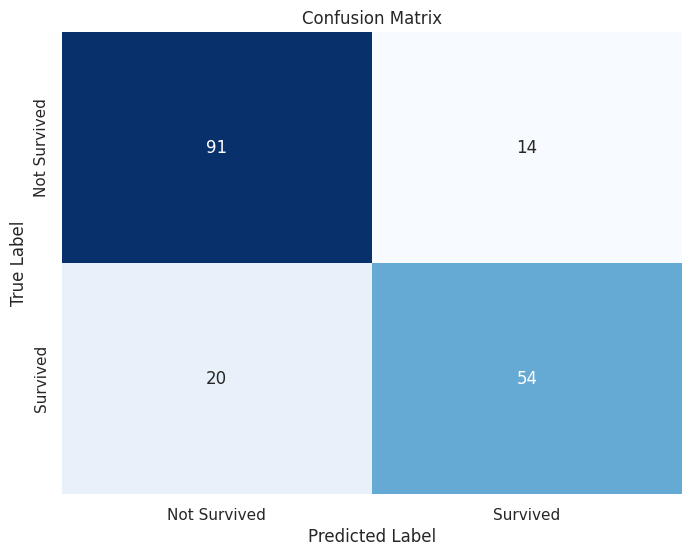

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])

# Labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

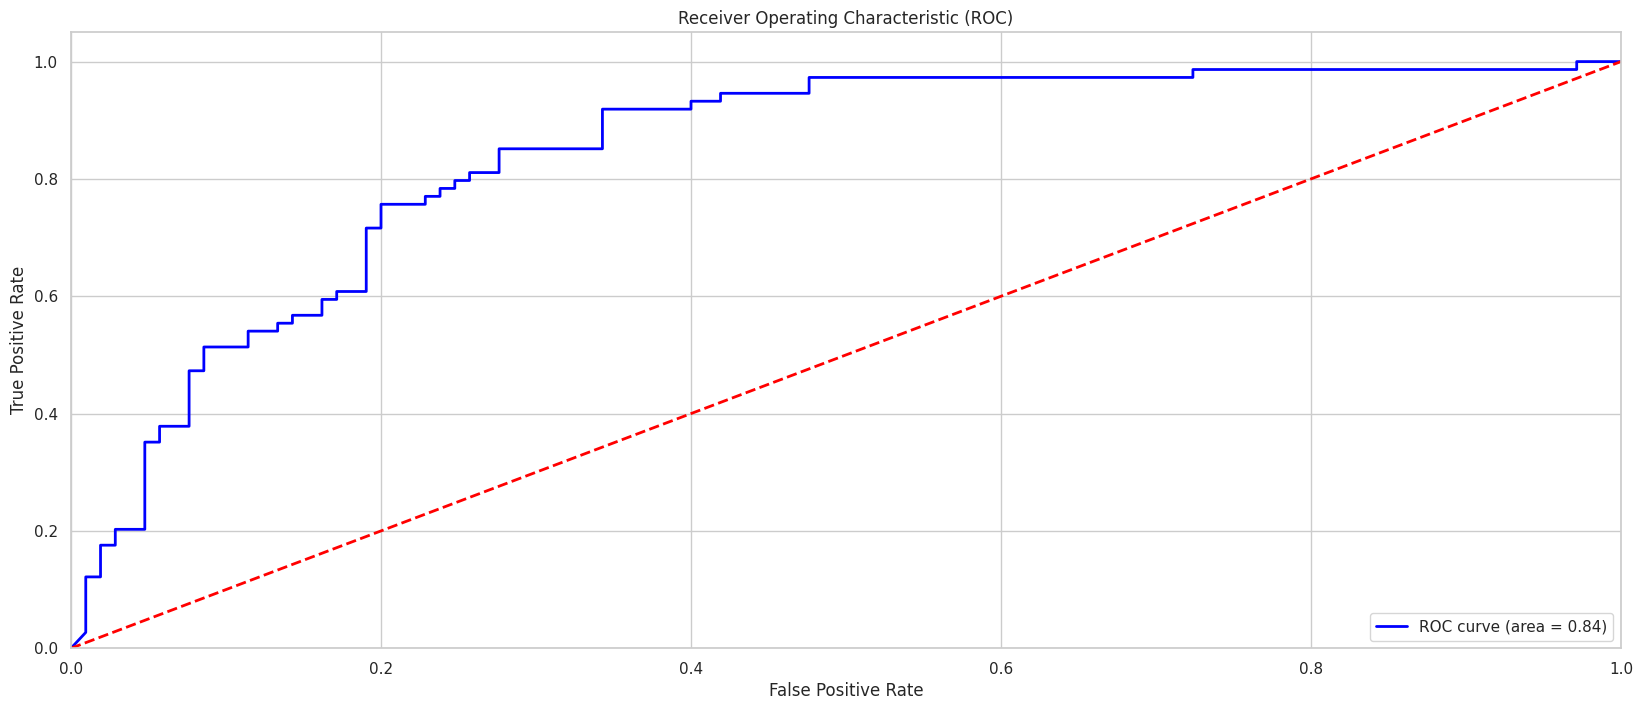

In [ ]:
# Make predictions on the testing data
y_pred_logreg = model.predict_proba(X_test)[:, 1]

# Compute the ROC curve and area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(20, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Decision Tree Classifier

In [ ]:
# Split the data into features (X) and target variable (y)
X = titanic_final.drop('survived_1', axis=1)
y = titanic_final['survived_1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dt = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Accuracy: 78.77%

Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.81      0.82       105
        True       0.74      0.76      0.75        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



## Confusion Matrix

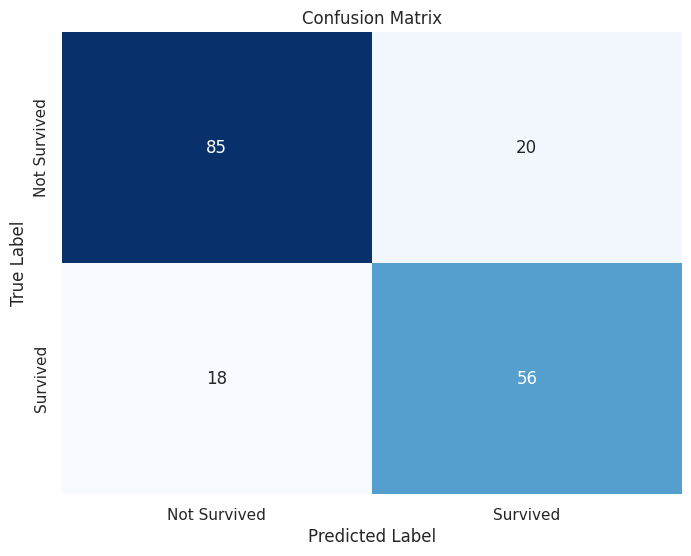

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])

# Labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

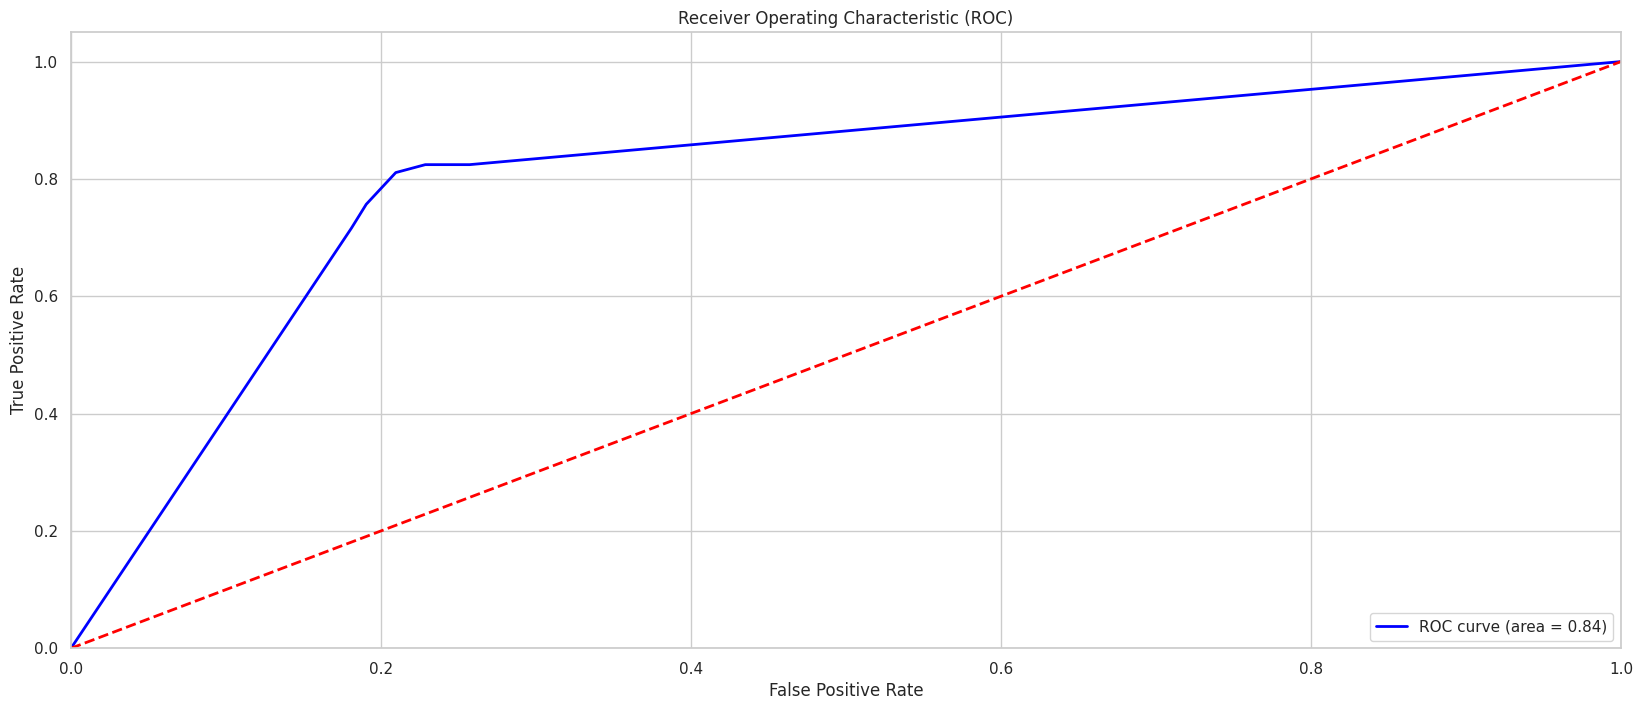

In [ ]:
# Make predictions on the testing data
y_pred_dt = clf.predict_proba(X_test)[:, 1]

# Compute the ROC curve and area under the curve (AUC)
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_dt)
roc_auc2 = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(20, 8))
plt.plot(fpr2, tpr2, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Naive Bayes

In [ ]:
# Split the data into features (X) and target variable (y)
X = titanic_final.drop('survived_1', axis=1)
y = titanic_final['survived_1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Gaussian Naive Bayes classifier
classifier = GaussianNB() #all variable have a normal distribution

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_nb = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Accuracy: 77.65%

Classification Report:
               precision    recall  f1-score   support

       False       0.79      0.84      0.81       105
        True       0.75      0.69      0.72        74

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.78      0.78      0.77       179



## Confusion Matrix

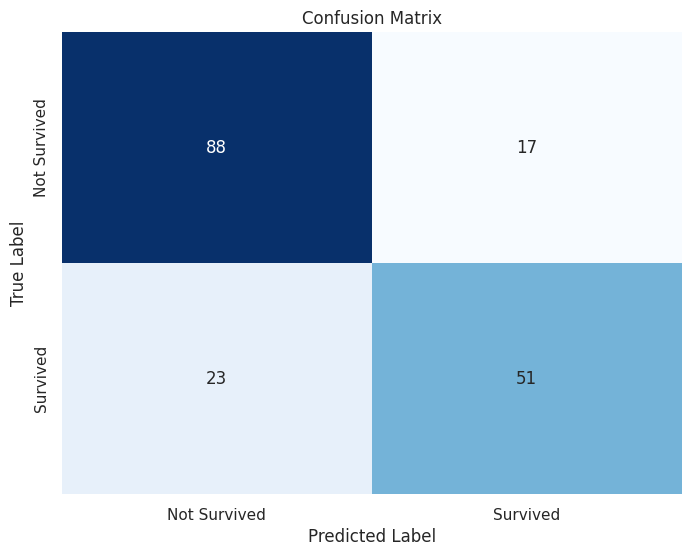

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])

# Labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

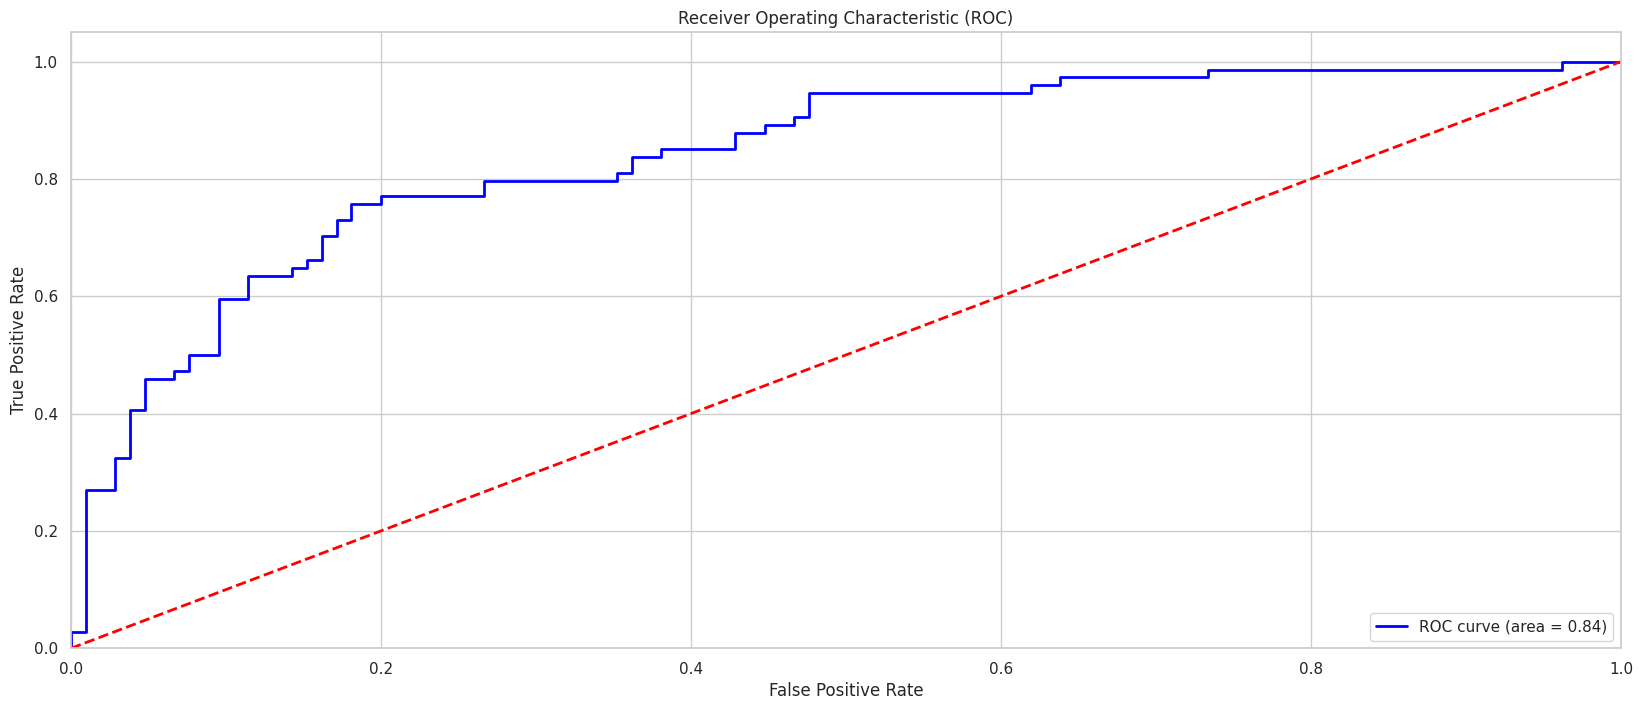

In [ ]:
# Make predictions on the testing data
y_pred_nb = classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve and area under the curve (AUC)
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_nb)
roc_auc3 = auc(fpr3, tpr3)

# Plot the ROC curve
plt.figure(figsize=(20, 8))
plt.plot(fpr3, tpr3, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Gradient Boosting Classifier

In [ ]:
# Split the data into features (X) and target variable (y)
X = titanic_final.drop('survived_1', axis=1)
y = titanic_final['survived_1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_classifier.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_gb)

print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

Accuracy: 82.68%

Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.88      0.86       105
        True       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



## Confusion Matrix

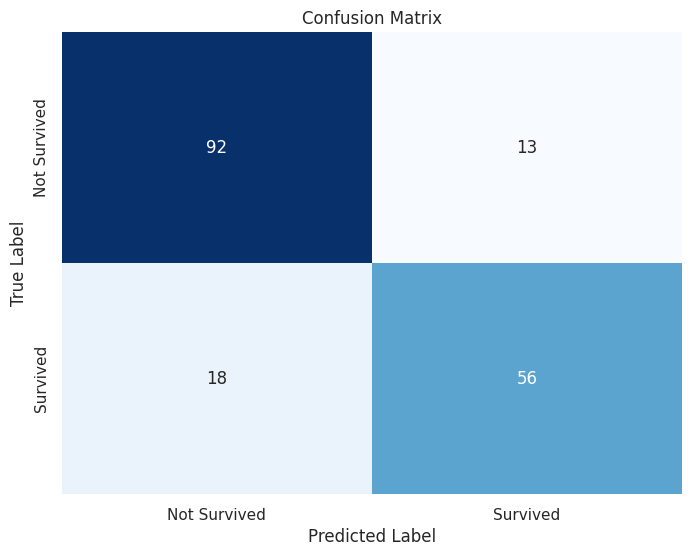

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_gb)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])

# Labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

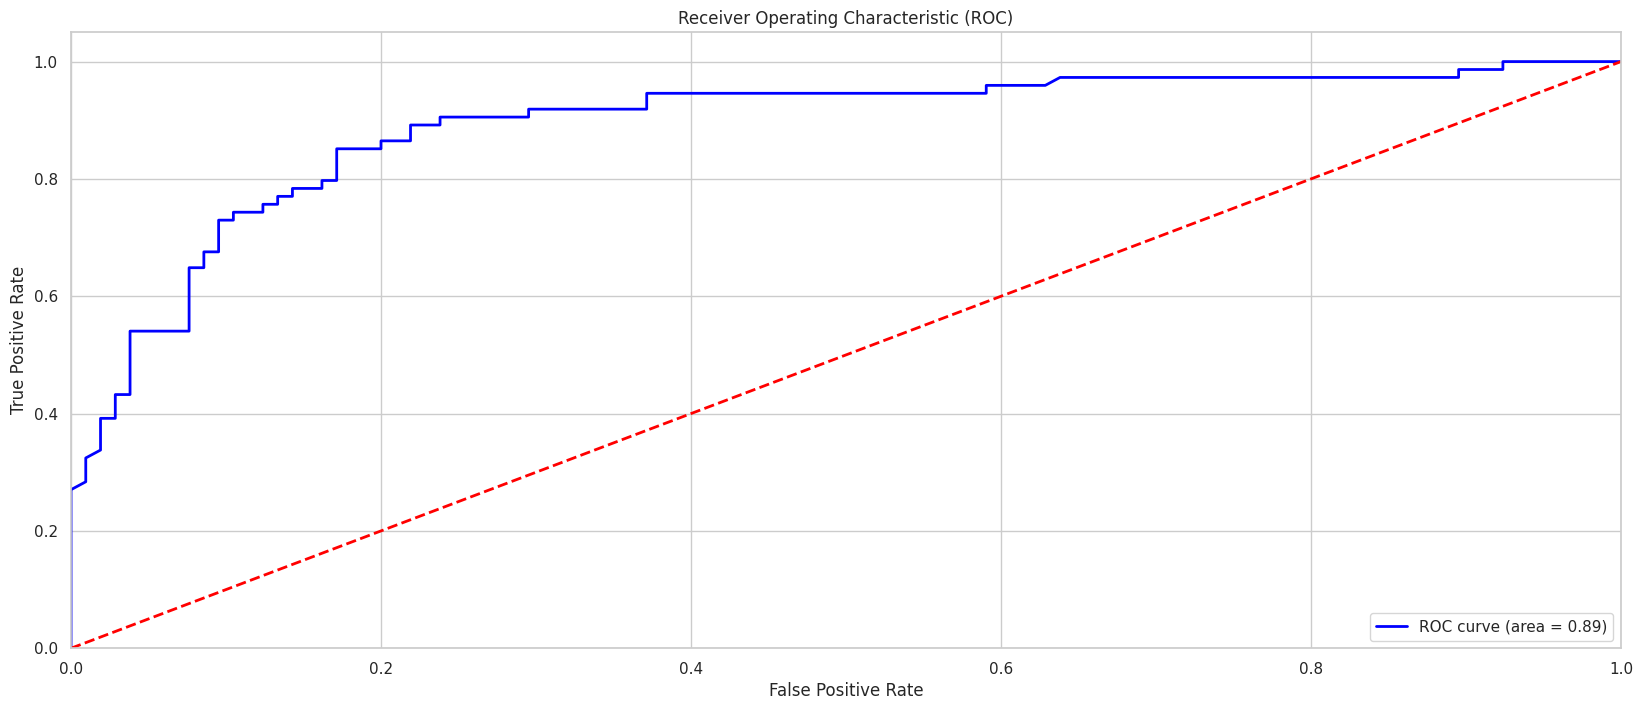

In [ ]:
# Make predictions on the testing data
y_pred_gb = gb_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve and area under the curve (AUC)
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_gb)
roc_auc4 = auc(fpr4, tpr4)

# Plot the ROC curve
plt.figure(figsize=(20, 8))
plt.plot(fpr4, tpr4, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc4)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Random Forest Classifier

In [ ]:
# Split the data into features (X) and target variable (y)
X = titanic_final.drop('survived_1', axis=1)
y = titanic_final['survived_1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_classifier.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, rf_predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, rf_predictions))

Accuracy: 81.56%

Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.86      0.85       105
        True       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



## Confusion Matrix

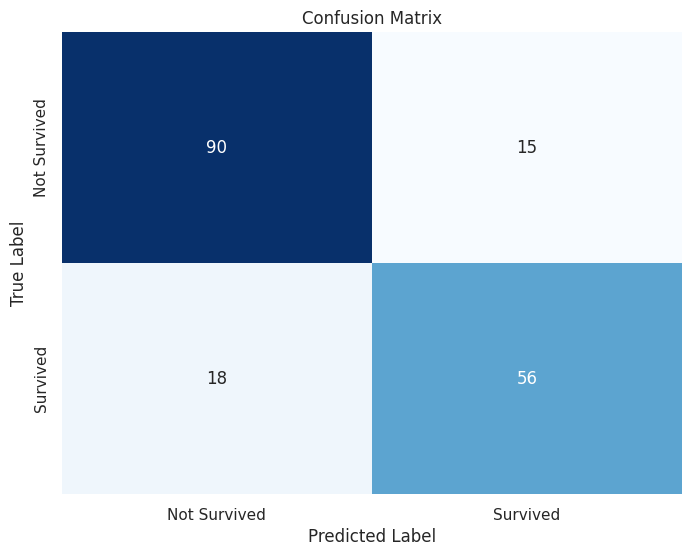

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])

# Labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

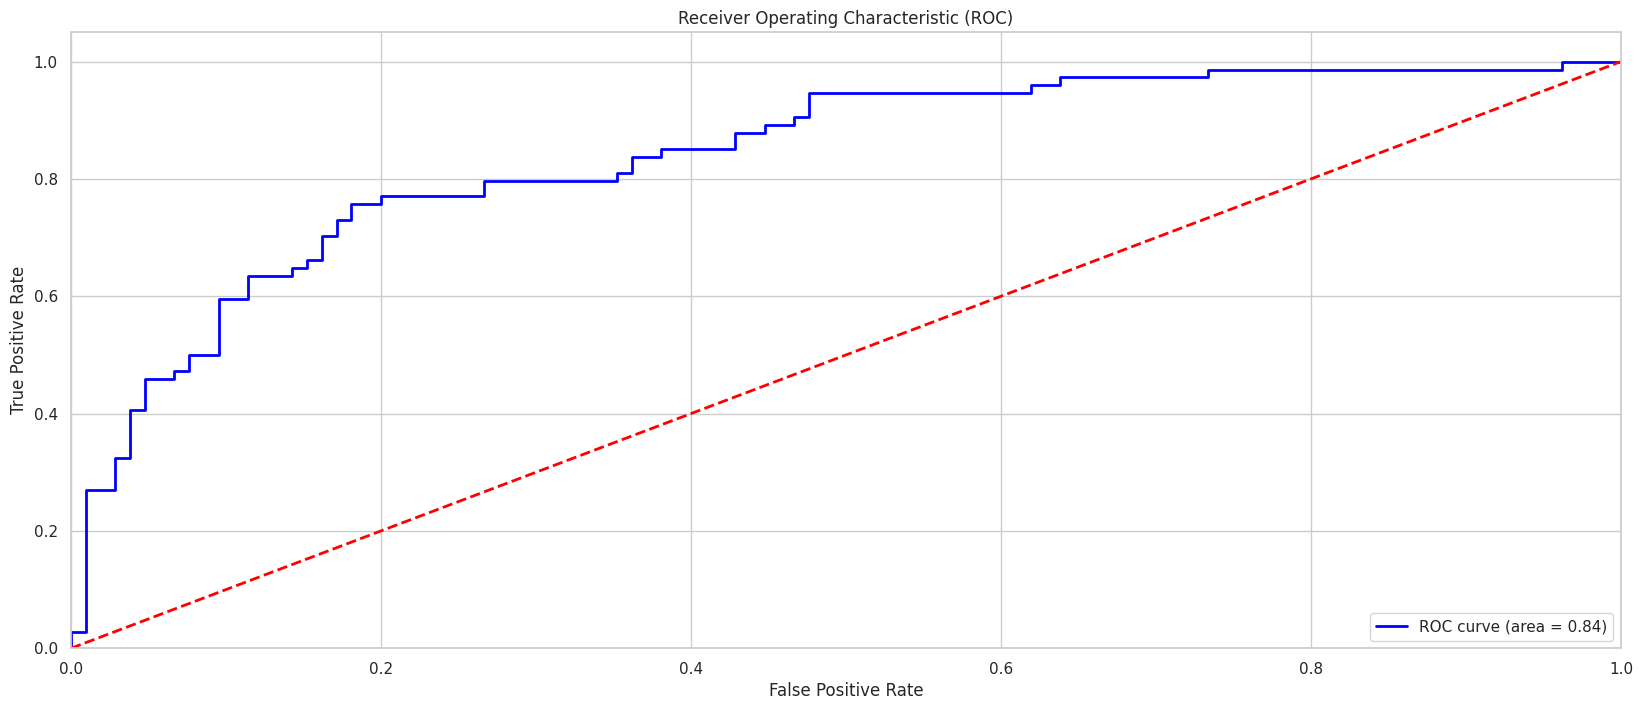

In [ ]:
# Make predictions on the testing data
rf_predictions = classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve and area under the curve (AUC)
fpr5, tpr5, thresholds = roc_curve(y_test, rf_predictions)
roc_auc5 = auc(fpr5, tpr5)

# Plot the ROC curve
plt.figure(figsize=(20, 8))
plt.plot(fpr5, tpr5, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc5)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# ROC Curve with All Models

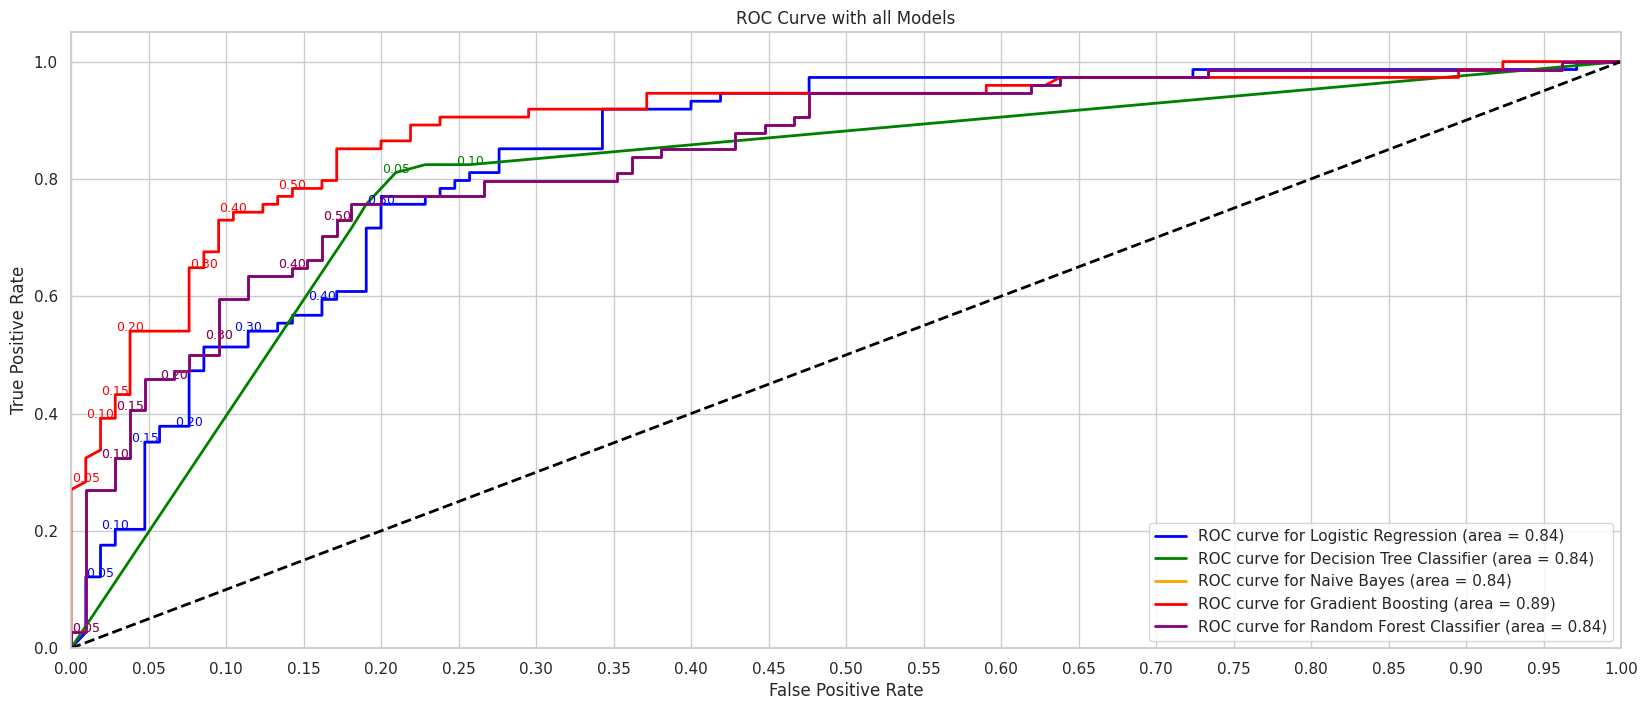

In [ ]:
# Specific threshold values to annotate
thresholds_to_annotate = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]

# Plot the ROC curve
plt.figure(figsize=(20, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve for Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='green', lw=2, label='ROC curve for Decision Tree Classifier (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='orange', lw=2, label='ROC curve for Naive Bayes (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='red', lw=2, label='ROC curve for Gradient Boosting (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='purple', lw=2, label='ROC curve for Random Forest Classifier (area = %0.2f)' % roc_auc5)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Annotate only the specified thresholds
for thresh in thresholds_to_annotate:
    # Get the index closest to the threshold in terms of FPR
    idx = np.argmin(np.abs(np.linspace(0, 1, num=len(fpr)) - thresh))

    if idx < len(fpr):
        plt.text(fpr[idx], tpr[idx], f'{thresh:.2f}', fontsize=9, color='blue', ha='center')
    if idx < len(fpr2):
        plt.text(fpr2[idx], tpr2[idx], f'{thresh:.2f}', fontsize=9, color='green', ha='center')
    if idx < len(fpr3):
        plt.text(fpr3[idx], tpr3[idx], f'{thresh:.2f}', fontsize=9, color='orange', ha='center')
    if idx < len(fpr4):
        plt.text(fpr4[idx], tpr4[idx], f'{thresh:.2f}', fontsize=9, color='red', ha='center')
    if idx < len(fpr5):
        plt.text(fpr5[idx], tpr5[idx], f'{thresh:.2f}', fontsize=9, color='purple', ha='center')

plt.xticks(np.arange(0, 1.05, 0.05))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with all Models')
plt.legend(loc="lower right")
plt.show()

## Analysis of ROC Curve with All Models

At the threshold of 5%, 10%, 15%, 20%, 30%, 40% and 50%, the Logistic Regression, Gradient Boosting, and Random Forest Classifier, have similar results. However, since the Gradient Boosting covers more area under the curve, it is a better model. The best model is Gradient Boosting as it has the highest true positive rate with low false positive rate.

It is necessary to have a low, if not 0%, false positive rate since the false positive rate refers to survived individuals being predicted as not survived. This can be acheieved by having a low threshold as the lower the threshold, the lower the false positive rate. Hence, the Gradient Boosting is a good model since it has higher accuracy with lower false positive rate.

Another good model is Decision Tree Classifier, because at 5% threshold, it has higher accuracy with high false positive rate. However, because of the steady increase from 0 to 0.22 false positive rate, the presence of high false negatives can be identified.

False negatives represent individuals being predicted as survived when they have not. Higher false negatives are acceptable, however higher false positives are not acceptable; hence with a lower accuracy, Decision Tree Classifier can be the best model as it will have lower false positives but higher false negatives.

This is also reflected in the confusion matrices created above where each of the model has the following results:

- Logisitic Regression
  - False Negative (Not Survived as Survived): 14
  - False Positive (Survived as Not Survived): 20

- Decision Tree Classifier
  - False Negative (Not Survived as Survived): 22
  - False Positive (Survived as Not Survived): 17

- Naive Bayes
  - False Negative (Not Survived as Survived): 17
  - False Positive (Survived as Not Survived): 23

- Gradient Boosting
  - False Negative (Not Survived as Survived): 13
  - False Positive (Survived as Not Survived): 18

- Random Forest Classifier
  - False Negative (Not Survived as Survived): 15
  - False Positive (Survived as Not Survived): 18

Through the confusion matrices, the earlier hypothesised theory that Decision Tree Classifier has more false negatives and lower false positives is proven to be correct.

However, Gradient Boosting can be considered as the best because it has much higher accuracy than Decision Tree Classifier with only 1 more false positive.

Hence, in terms of accuracy, Gradient Boosting is the best model; but in terms of only low false positives, Decision Tree Classifier is the best model.